# **Image Classification Using Convolutional Neural Networks**

In this notebook, a model based on [convolutional neural networks (CNN)](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) is implemented for image classification using the [CIFAR-10 dataset](https://www.cs.toronto.edu/%7Ekriz/cifar.html). This dataset consists of 60,000 color (RGB) images, with 50,000 used for training and 10,000 for testing.

Best results in the notebooks:

- [ImageClassification_EfficientNetV2L_CIFAR-10](https://github.com/JersonGB22/ImageClassification-TensorFlow/blob/main/TransferLearningModels/ImageClassification_EfficientNetV2L_CIFAR-10.ipynb): Accuracy of **98.1%** on the test dataset.

- [ImageClassification_ViT_CIFAR-10](https://github.com/JersonGB22/ImageClassification-TensorFlow/blob/main/VisionTransformerModels/ImageClassification_ViT_CIFAR-10.ipynb): Accuracy of **99.02%** on the test dataset.



## **Imports**

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from google.colab import drive

## **Parameters**

In [42]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
epochs = 100
batch_size = 128
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123

## **Prepare the dataset for training**

### **Load the dataset**

In [3]:
(train_dataset, test_dataset), info = tfds.load("cifar10", split=["train", "test"], as_supervised=True, with_info=True)
info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/root/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learni

In [4]:
num_classes = info.features["label"].num_classes
class_names = info.features["label"].names
class_names = [name.capitalize() for name in class_names]

print("Number of classes:", num_classes)
print("Class names:", class_names)

Number of classes: 10
Class names: ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck'] 



### **Preprocessing and data augmentation**

To mitigate overfitting, it is crucial to employ data augmentation techniques, especially considering that the training dataset is relatively small. Data augmentation enhances the model's generalization capability for image classification. For this purpose, TensorFlow layers such as [``RandomFlip``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip), [``RandomTranslation``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomTranslation), [``RandomRotation``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation), and [``RandomZoom``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom) are used. These layers are applied exclusively to the training dataset during preprocessing, controlled by setting the parameter ``training=True``.

Regarding image preprocessing, the [``Resizing``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing) layer will be used to resize the images and make them compatible with the model and the [``Rescaling``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer to normalize the images in the range of ``[0;1]``. These two layers operate independently of the ``training`` parameter, so they are applied to both the training and testing datasets.

In [5]:
original_size = info.features["image"].shape
new_size = (224, 224, 3)

original_size, new_size

((32, 32, 3), (224, 224, 3))

In [6]:
def function_data_augmentation(input_shape, output_shape):
  return tf.keras.Sequential([
      tf.keras.Input(shape=input_shape),
      tf.keras.layers.Resizing(output_shape[0], output_shape[1]),
      tf.keras.layers.RandomFlip("horizontal"),
      tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
      tf.keras.layers.RandomRotation(0.1, fill_mode="nearest"),
      tf.keras.layers.RandomZoom(0.2, fill_mode="nearest"),
      tf.keras.layers.Rescaling(1/255)
  ], name="data_augmentation")

In [7]:
tf.keras.backend.clear_session() #Clearing Keras memory

data_augmentation = function_data_augmentation(original_size, new_size)
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_translation (Random  (None, 224, 224, 3)       0         
 Translation)                                                    
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3) 

In [8]:
def prepare_dataset(dataset, training=True):
  if training:
    dataset = dataset.shuffle(buffer_size, seed=SEED)

  dataset = (
      dataset.
      batch(batch_size).
      map(lambda x, y : (data_augmentation(x, training=training), y), num_parallel_calls=AUTOTUNE).
      prefetch(AUTOTUNE)
  )

  return dataset

In [9]:
train_dataset = prepare_dataset(train_dataset)
test_dataset = prepare_dataset(test_dataset, training=False)

In [10]:
# Take a batch from the training dataset
for images, labels in train_dataset.take(1):
  print(images.shape, labels.shape)

images.numpy().min(), images.numpy().max()

(128, 224, 224, 3) (128,)


(0.0, 1.0)

**Function to display and save images**

In [11]:
def show_images(images, labels, predictions=None, num_examples=36, random=True,
                cmap=None, axis="off", save=False, path=""):

  n = int(np.sqrt(num_examples))
  indices = np.arange(len(images))
  if random:
    np.random.shuffle(indices)

  fig, axes = plt.subplots(n, n, figsize=(1.3*n, 1.3*n))

  for i, ax in enumerate(axes.flat):
    ax.imshow(images[indices[i]], cmap=cmap)

    if predictions is not None:
      color = "#00008B" if labels[indices[i]] == predictions[indices[i]] else "red"

      ax.text(
          x=0.5, y=1.101, s=f"Label: {class_names[labels[indices[i]]]}", color=color, fontsize=6.85,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )
      ax.text(
          x=0.5, y=1, s=f"Pred: {class_names[predictions[indices[i]]]}", color=color, fontsize=6.85,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )

    else:
      ax.text(
          x=0.5, y=1, s=f"Label: {class_names[labels[indices[i]]]}", fontsize=6.85,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )

    ax.axis(axis)

  plt.tight_layout()
  # Save images
  if save:
    plt.savefig(path)

  plt.show()

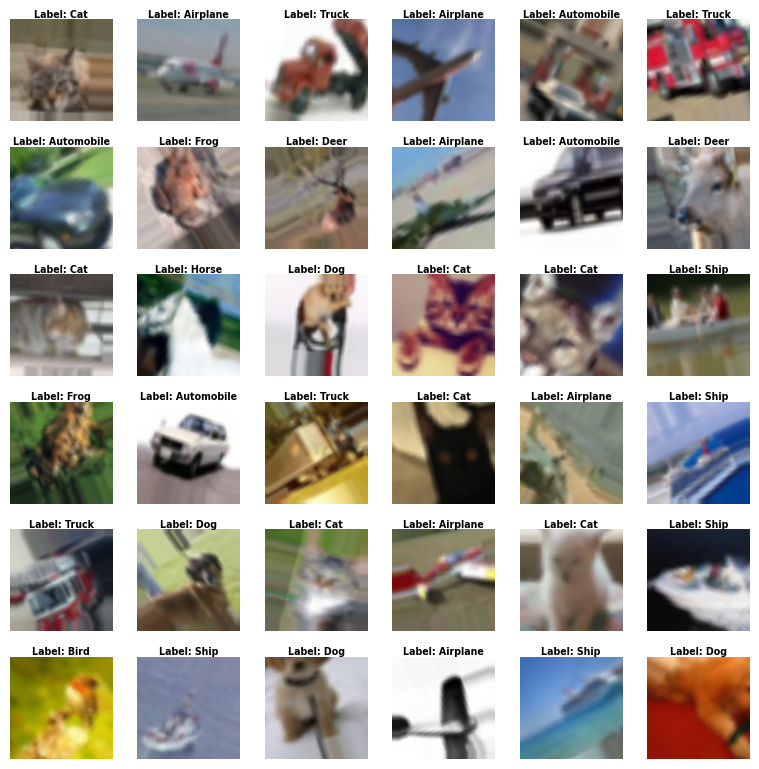

In [12]:
# Some images from the training dataset after data augmentation
show_images(images, labels, random=False)

## **Model building and training**

Since the convolutional model is trained from scratch, multiple epochs of training are required to achieve the best results. Therefore, the Google Colab TPU is used to speed up the training process.

In [13]:
# TPU setup

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU initialized:")
  print("All devices: ", tf.config.list_logical_devices("TPU"))
except (ValueError, tf.errors.InvalidArgumentError, tf.errors.NotFoundError) as error:
  print(f"Error: {error}")

TPU initialized:
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [14]:
def base_cnn(filters=32, dropout_rate=0.1, name=None):
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(filters, kernel_size=3, padding="same", activation="relu"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(filters, kernel_size=3, padding="same", activation="relu"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D(pool_size=2),
      tf.keras.layers.Dropout(dropout_rate)
  ], name=name)


def build_model(input_shape):
  return tf.keras.Sequential([
      tf.keras.Input(shape=input_shape),
      base_cnn(filters=32, name="block_conv_1"),
      base_cnn(filters=64, name="block_conv_2"),
      base_cnn(filters=128, name="block_conv_3"),
      base_cnn(filters=256, name="block_conv_4"),
      base_cnn(filters=512, name="block_conv_5"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation="relu"),
      tf.keras.layers.Dense(num_classes, activation="softmax")
  ])

In [15]:
tf.keras.backend.clear_session()

with strategy.scope():
  model = build_model(new_size)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(0.001),
      loss="sparse_categorical_crossentropy",
      metrics=["accuracy"],
      steps_per_execution=50
  )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block_conv_1 (Sequential)   (None, 112, 112, 32)      10400     
                                                                 
 block_conv_2 (Sequential)   (None, 56, 56, 64)        55936     
                                                                 
 block_conv_3 (Sequential)   (None, 28, 28, 128)       222464    
                                                                 
 block_conv_4 (Sequential)   (None, 14, 14, 256)       887296    
                                                                 
 block_conv_5 (Sequential)   (None, 7, 7, 512)         3544064   
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3

In [16]:
# Necessary libraries to plot the model architecture on the Colab TPU
!pip install pydot graphviz -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.3 MB/s eta 0:00:00


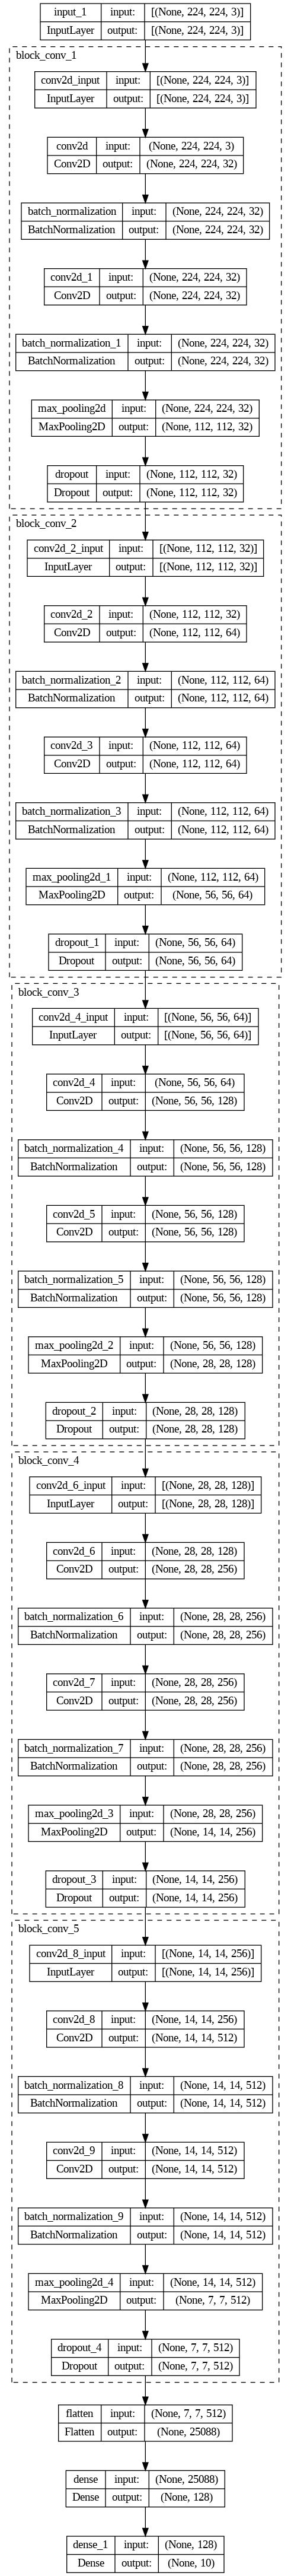

In [16]:
# Visualizing the architecture of the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [17]:
# Callback to stop training early if validation accuracy does not improve for 7 epochs
patience = 7
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=patience,
    restore_best_weights=True
)

In [18]:
# Train the model
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[callback])

Epoch 1/100
391/391 [==============================] - 113s 289ms/step - loss: 2.4647 - accuracy: 0.2413 - val_loss: 2.8994 - val_accuracy: 0.1706
Epoch 2/100
391/391 [==============================] - 40s 103ms/step - loss: 1.8250 - accuracy: 0.3252 - val_loss: 1.7925 - val_accuracy: 0.3490
Epoch 3/100
391/391 [==============================] - 41s 104ms/step - loss: 1.6202 - accuracy: 0.4009 - val_loss: 1.5307 - val_accuracy: 0.4412
Epoch 4/100
391/391 [==============================] - 41s 104ms/step - loss: 1.4573 - accuracy: 0.4654 - val_loss: 1.3837 - val_accuracy: 0.5032
Epoch 5/100
391/391 [==============================] - 41s 104ms/step - loss: 1.3236 - accuracy: 0.5200 - val_loss: 1.1548 - val_accuracy: 0.5864
Epoch 6/100
391/391 [==============================] - 41s 106ms/step - loss: 1.2012 - accuracy: 0.5644 - val_loss: 1.0887 - val_accuracy: 0.6097
Epoch 7/100
391/391 [==============================] - 41s 104ms/step - loss: 1.1108 - accuracy: 0.6038 - val_loss: 1.0788 

**Save the model**

In [43]:
trained_model_path = "/content/drive/MyDrive/models/ImageClassification_CNN_CIFAR-10.keras"
model.save(trained_model_path)

## **Model Evaluation**

In [19]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.2074538618326187, 0.9292799830436707]
[0.3437555432319641, 0.9021000266075134]


In [44]:
(0.9292799830436707- 0.9021000266075134) * 100

2.7179956436157227

### **Graphs of the metrics**

In [20]:
# Library needed to convert Plotly interactive graphics into images
!pip install kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.7 MB/s eta 0:00:00


In [21]:
# Function to plot the metrics
def plot_metrics(history=history.history, metric="loss", renderer=None, with_patience=True):
  epochs = len(history["loss"])
  losses = history[metric]
  val_losses = history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))

  last_epoch = epochs-patience if with_patience else epochs
  fig.add_vline(
      x=last_epoch, line=dict(color="red", width=2, dash="dash"),
      annotation_text="End of Training", annotation_position="top left",
      annotation=dict(font_size=12, font_color="red")
  )

  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [22]:
# Interactive graphic
plot_metrics(metric="accuracy")
plot_metrics()

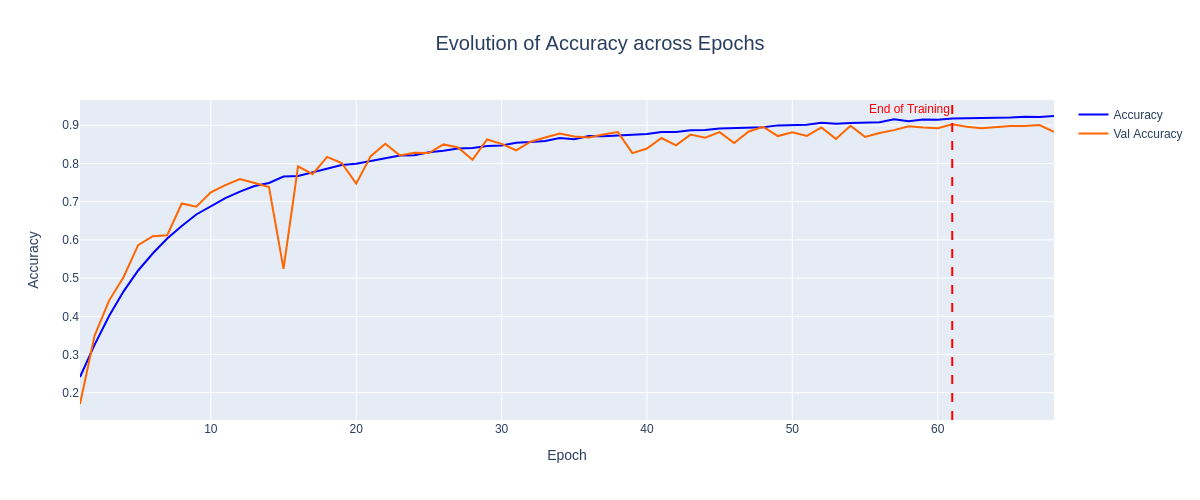

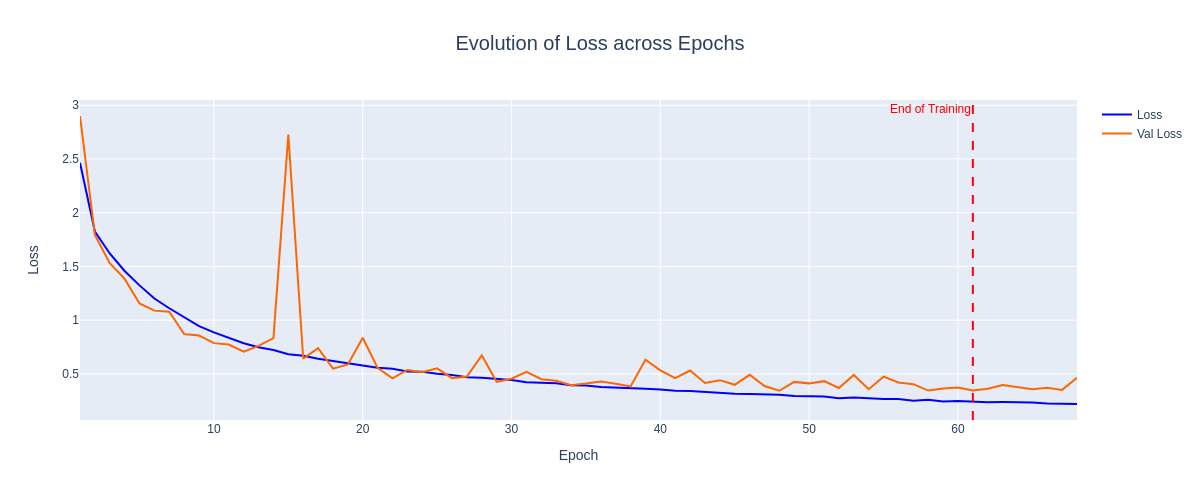

In [23]:
# Static image for GitHub
plot_metrics(metric="accuracy", renderer="png")
plot_metrics(renderer="png")

### **Confusion Matrix**

In [24]:
# Extract labels from the test dataset
labels_test = test_dataset.unbatch().map(lambda image, label: label)
labels_test = np.array(list(labels_test.as_numpy_iterator()))

# Generate predictions with the trained model
labels_test_pred = model.predict(test_dataset, verbose=0)
labels_test_pred = np.argmax(labels_test_pred, axis=-1)

# Consolidating the accuracy of the test dataset
print("Accuracy:", np.mean(labels_test == labels_test_pred))
print(f"F1 Score: {f1_score(labels_test, labels_test_pred, average='macro')}")

Accuracy: 0.9021
F1 Score: 0.9024238847848742


Frequency per Label: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000] 



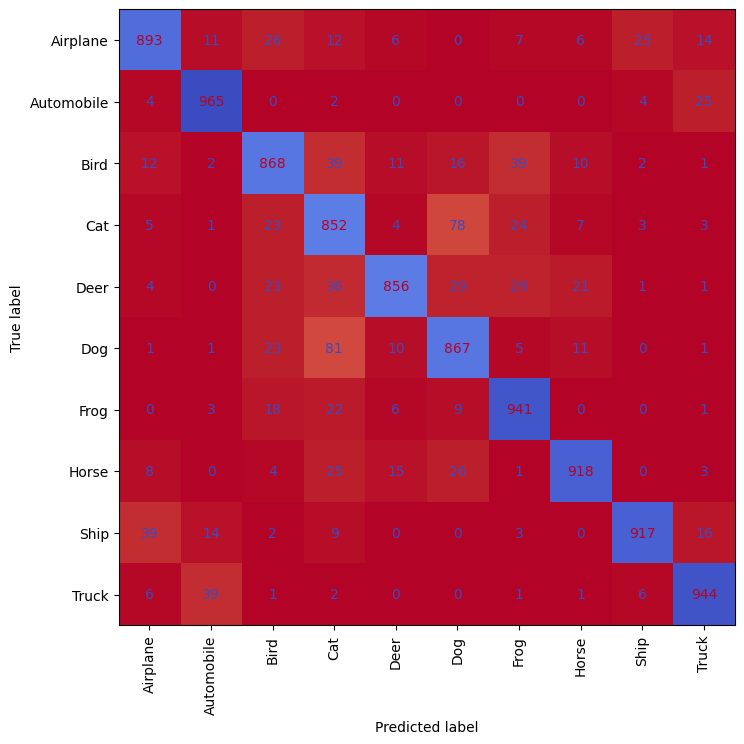

In [25]:
print("Frequency per Label:", np.unique(labels_test, return_counts=True)[1], "\n")

cm = confusion_matrix(labels_test, labels_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
cmd.plot(ax=ax, colorbar=False, cmap="coolwarm_r", xticks_rotation="vertical");

The test dataset is balanced, with 1,000 images per label. Additionally, the confusion matrix shows that the model has more difficulty distinguishing between the ``Cat``, ``Dog``, ``Deer``, and ``Bird`` categories, while it performs better in classifying the ``Automobile`` category.

## **Predictions on the test dataset**

In [26]:
# Extract images from the test dataset
images_test = test_dataset.unbatch().map(lambda image, label: image)
images_test = np.array(list(images_test.as_numpy_iterator()))

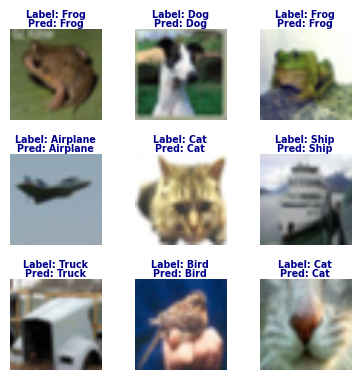

In [27]:
show_images(images_test, labels_test, labels_test_pred, num_examples=9)

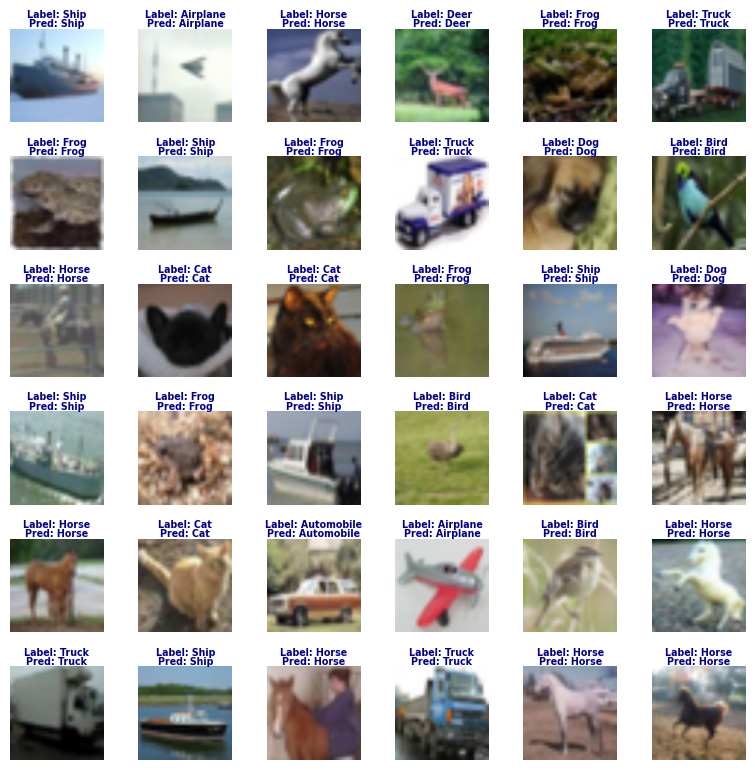

In [41]:
show_images(
    images_test, labels_test, labels_test_pred,
    save=True, path="ImageClassification_CNN_CIFAR-10.png"
)

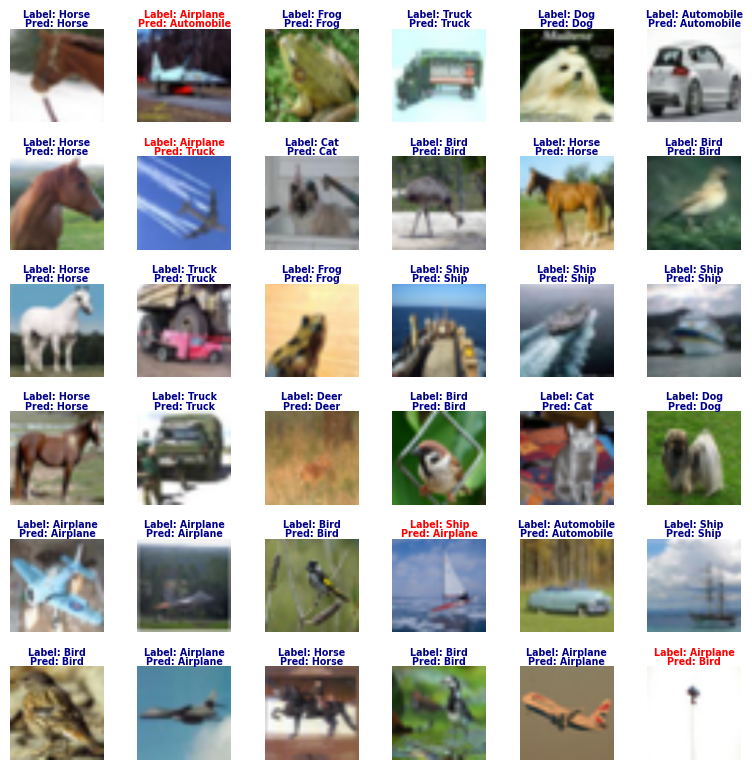

In [40]:
show_images(images_test, labels_test, labels_test_pred, random=False)

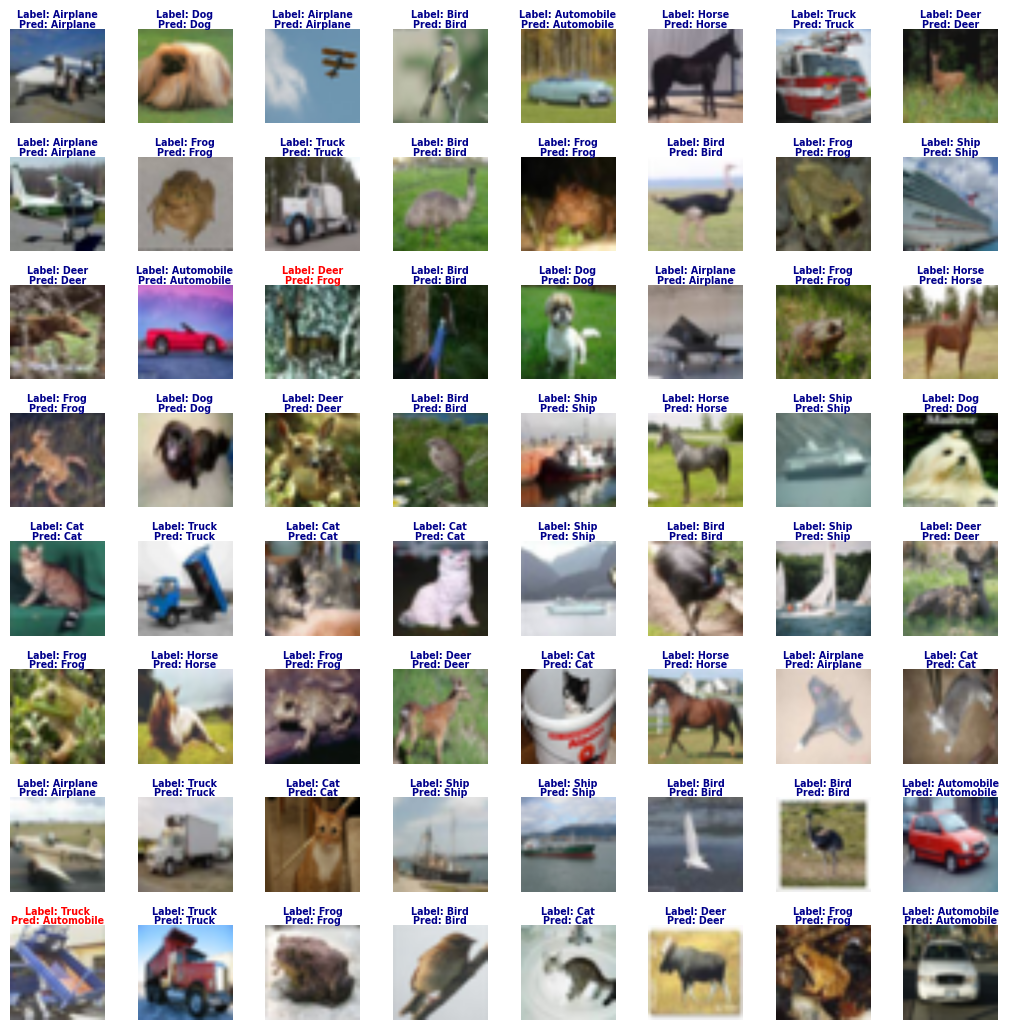

In [35]:
show_images(images_test, labels_test, labels_test_pred, num_examples=64)

**Conclusion:** The model achieved an accuracy of **92.93%** on the training dataset and **90.21%** on the test dataset, along with an F1 score of **90.24%**. This **2.72%** difference in accuracies between the datasets suggests only slight overfitting, indicating that data augmentation, dropout layers, and the early stopping callback were effective. Additionally, the model shows a good balance between precision and recall, as the F1 score and accuracy are nearly identical in the evaluation. If training were to continue for more epochs, the training accuracy would likely reach 100%, while the test accuracy might start to decline or plateau.

These results are promising, considering that the model was trained from scratch and achieved accuracies above 90%. To achieve better results on the CIFAR-10 dataset, it would be advisable to use a more advanced model architecture, leveraging transfer learning or fine-tuning, allowing the use of state-of-the-art CNNs or Vision Transformers.